# Anomaly Detection Neural Network with Attention

This notebook consists of four main parts to describe the workflow of training a Recurrent Neural Network with attention layer model to classify anomaly events in a sequence based embeded software log. These four parts are Data Loading and Preprocessing, Model building, Model training, Results Analysis and Visualization.

The evaluate of new test data will be presented in another notebook.


* Connect with google drive and import libraries

In [6]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
import os
import sys
import time
import re
import pickle
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
import keras

TensorFlow 2.x selected.


Using TensorFlow backend.


In [0]:
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

## model.py file contains Encoder, Attention, and Decoder class method
from model import *
## utils.py file contains build_data, tokenize, load_dataset, convert functions.
from utils import *

# Data loading and preprocessing

* Load in all 15 .csv data files, and save as pandas dataframes.

In [0]:
# name_list is used to store all the global variables names
name_list=[]
for subdir,dirs,files in os.walk("/content/gdrive/My Drive/AnomalyDetectionChallenge/"):
    for file in files:
        if 'hexacopter-hil-' in file:
            directory=os.path.join(subdir,file)
            name=re.search('/content/gdrive/My Drive/AnomalyDetectionChallenge/hexacopter-hil-(.*).kev.csv',directory).group(1)
            name_list.append(name)
            globals()[name]=pd.read_csv(directory)

#### Overview of the data

* Groupby `class` and `event` column in the dataframe to get the occurrence count of different events under different class.

In [0]:
df=pd.DataFrame(index=globals()[name_list[0]].groupby(['class','event']).size().index)
for name in name_list:
    name_df=globals()[name].groupby(['class','event']).size()
    df=df.join(pd.DataFrame(name_df),how="outer")
    df=df.rename(columns={0:name})
    
df=df[sorted(df.columns)]

In [0]:
df.head(10)

clean-01  clean-02  ...  full-while  half-while
class   event                              ...                        
COMM    MSG_ERROR           6.0       6.0  ...       509.0       422.0
        REC_MESSAGE     17968.0   17969.0  ...     44802.0     45072.0
        REC_PULSE       24710.0   24226.0  ...     39342.0     39529.0
        REPLY_MESSAGE   17947.0   17950.0  ...     44202.0     44565.0
        SIGNAL              NaN       1.0  ...         NaN         1.0
        SND_MESSAGE     18089.0   18077.0  ...     45149.0     45426.0
        SND_PULSE           NaN       NaN  ...     11226.0     11289.0
        SND_PULSE_DIS       NaN       NaN  ...         NaN         NaN
        SND_PULSE_EXE   36701.0   48219.0  ...    172297.0    160365.0
CONTROL BUFFER           2161.0    2158.0  ...      4326.0      4334.0

[10 rows x 15 columns]

From above table, it could be seen that the clean and anomalous files are quite different based on the occurrence counts of different events. For example, normally event `COMM-SND_MESSAGE` occurced around 18000 times, while in the anomalous files it occured around 45000~67000 times. This may not be seen as an effective way to detect anomalous activity, however, it can show a general picture of the data where the anomaly could be residing.

#### data preprocessing



In [1]:
## extract class and event columns from clean dataframes, and concat these two columns
X=[]
Y=[]
for i in range(10):
  data=globals()[sorted(name_list)[i]][['class','event']]
  data=list(data['class']+data['event'])
  inp,tar=build_data(data,5,1)
  X=X+inp
  Y=Y+tar

NameError: ignored

In [0]:
# Create a sequence tokenizer and fit on events combinations
seq_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',oov_token='400')
seq_tokenizer.fit_on_texts(X)


# saving the Tokenizer in file for test use.
with open('./gdrive/My Drive/Colab Notebooks/tokenizer.pickle', 'wb') as handle:
    pickle.dump(seq_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
## load_dataset function converts text data X,Y into sequence tensors.
input_tensor, target_tensor = load_dataset(X, Y, seq_tokenizer)
input_tensor_train=input_tensor
target_tensor_train=target_tensor

In [0]:
print('Number of training examples: ', len(input_tensor_train))
print('Number of training targets: ', len(target_tensor_train))

Number of training examples:  7343805
Number of training targets:  7343805


In [0]:
# show examples
print ("Input seq; index to word mapping")
convert(input_tensor_train[0], seq_tokenizer)
print ()
print ("Target Language; index to word mapping")
convert(target_tensor_train[0], seq_tokenizer)

Input seq; index to word mapping
2 ----> <start>
40 ----> controlbuffer
39 ----> controltime
79 ----> processproccreate_name
77 ----> threadthcreate
5 ----> threadthready

Target Language; index to word mapping
2 ----> <start>
77 ----> threadthcreate
8 ----> threadthreceive
77 ----> threadthcreate
8 ----> threadthreceive
77 ----> threadthcreate


#### Create a tf.data dataset

In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 256
steps_per_epoch = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 64
units = 128
vocab_inp_size = len(seq_tokenizer.word_index)+1
vocab_tar_size = len(seq_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

# Model Building

* Load the encoder and decoder model

The architecture of this model is:

`input of events sequence` ------>> `encoder(GRU unit)` ------>> `attention layer` ----->> `decoder (GRU unit)` ------->> `output layer`

The input is a small segment of the log file, in this case, 5 continuous events, and the target output is the next 5 continuous events following the input one. The general idea is that using this proposed NN model to train inputs and predicting the following outputs. Assuming the event sequences patterns between the clean and anomalous ones are different, then the preciting/test accuracy should be different using the same model and trained weights. 

Check model.py file for the details of encoder, attention, and decoder models.

In [2]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

NameError: ignored

* Model compile

In [0]:
optimizer = tf.keras.optimizers.Adam(lr=0.05, beta_1=0.9, beta_2=0.999, decay=0.01)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [0]:
checkpoint_dir = './gdrive/My Drive/checkpoints/sumitmodel'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

# Model training

* Define train step

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
      
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([seq_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        batch_results=[]

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
          # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            predicted_id = tf.argmax(predictions,axis=1,output_type=tf.int32)

            batch_results.append(predicted_id)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    accuracy= tf.reduce_sum(tf.cast(tf.equal(targ[:,1:], tf.transpose(batch_results, [1, 0])),tf.float32)/float(BATCH_SIZE*(targ.shape[1]-1)))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss,accuracy

* Training the model

In [0]:

EPOCHS = 2

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    epoch_accuracy =0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
            batch_loss,accuracy = train_step(inp, targ, enc_hidden)
            total_loss += batch_loss
            epoch_accuracy+=accuracy

            if batch % 500 == 0:
                print('Epoch {} Batch {} Loss {:.4f}, Accuracy {}'.format(epoch + 1,
                                                                   batch,
                                                                   batch_loss.numpy(),
                                                                   accuracy))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 1 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f} ,Accuracy {}'.format(epoch + 1,
                                          total_loss / steps_per_epoch,
                                          epoch_accuracy/steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.3152, Accuracy 0.875001072883606
Epoch 1 Batch 500 Loss 0.3880, Accuracy 0.863282322883606
Epoch 1 Batch 1000 Loss 0.2742, Accuracy 0.8992199301719666
Epoch 1 Batch 1500 Loss 0.3310, Accuracy 0.867188572883606
Epoch 1 Batch 2000 Loss 0.3475, Accuracy 0.8695323467254639
Epoch 1 Batch 2500 Loss 0.3617, Accuracy 0.867188572883606
Epoch 1 Batch 3000 Loss 0.3258, Accuracy 0.8781260848045349
Epoch 1 Batch 3500 Loss 0.3206, Accuracy 0.875001072883606
Epoch 1 Batch 4000 Loss 0.3208, Accuracy 0.8796886205673218
Epoch 1 Batch 4500 Loss 0.3301, Accuracy 0.871094822883606
Epoch 1 Batch 5000 Loss 0.3790, Accuracy 0.868751049041748
Epoch 1 Batch 5500 Loss 0.2592, Accuracy 0.9023449420928955
Epoch 1 Batch 6000 Loss 0.2920, Accuracy 0.8898448944091797
Epoch 1 Batch 6500 Loss 0.3269, Accuracy 0.880469799041748
Epoch 1 Batch 7000 Loss 0.3009, Accuracy 0.8945324420928955
Epoch 1 Batch 7500 Loss 0.3214, Accuracy 0.882813572883606
Epoch 1 Batch 8000 Loss 0.3116, Accuracy 0.8820323348

# Results Analysis and Visualization

* Define evaluate function

In [0]:
def evaluate(input):

  inputs = tf.convert_to_tensor(input)

  #result = ''
  result=[]

  hidden = [tf.zeros((len(input),units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([seq_tokenizer.word_index['<start>']]*len(input), 1)

  for t in range(input.shape[1]-1):
    predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_out)

    predicted_id = tf.argmax(predictions,axis=1).numpy()

    #result += targ_seq.index_word[predicted_id] + ' '

    result.append(predicted_id)

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims(predicted_id, 1)

  return result

* test data preprocessing

In [0]:
name_list=['clean-01',
 'clean-02',
 'clean-03',
 'clean-04',
 'clean-05',
 'clean-06',
 'clean-07',
 'clean-08',
 'clean-09',
 'clean-10',
 'fifo-ls-01',
 'fifo-ls-02',
 'fifo-ls-sporadic',
 'full-while',
 'half-while']

The next step is to predict results using the above model and trained weights of each layer.

The test inputs are processed using event sequence length `Tx = 5`, same as the trained data, while using stride `stride = 5` instead of 2.

Save all the predicted result into .npy files for further analysis use.

In [0]:
from tqdm import tqdm
s=10000
for j in range(len(sorted(name_list))):
  data=globals()[sorted(name_list)[j]][['class','event']]
  data=list(data['class']+data['event'])
  X,Y=build_data(data,Tx=5,stride=5)
  test_input_tensor, test_target_tensor= load_dataset(X, Y, seq_tokenizer)

  pre=np.empty(0)

  for i in tqdm(range(0,test_input_tensor.shape[0]-s+1,s)):
    t=evaluate(test_input_tensor[i:i+s,:])
    t=np.array(t).swapaxes(0,1)
    pre=np.append(pre,t)

  pre=np.append(pre,np.array(evaluate(test_input_tensor[i+s:,:])).swapaxes(0,1))

  ## save predicted values
  np.save('./gdrive/My Drive/Colab Notebooks/test_results/{}-predicted.npy'.format(sorted(name_list)[j]),pre)
  ## save inputs
  np.save('./gdrive/My Drive/Colab Notebooks/test_results/{}-input.npy'.format(sorted(name_list)[j]),test_input_tensor)
  ## save targets
  np.save('./gdrive/My Drive/Colab Notebooks/test_results/{}-target.npy'.format(sorted(name_list)[j]),test_target_tensor)

number of training examples: 136011


100%|██████████| 13/13 [00:23<00:00,  1.76s/it]


number of training examples: 137155


100%|██████████| 13/13 [00:22<00:00,  1.74s/it]


number of training examples: 139337


100%|██████████| 13/13 [00:22<00:00,  1.76s/it]


number of training examples: 144015


100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


number of training examples: 146569


100%|██████████| 14/14 [00:24<00:00,  1.78s/it]


number of training examples: 147955


100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


number of training examples: 150595


100%|██████████| 15/15 [00:26<00:00,  1.78s/it]


number of training examples: 152932


100%|██████████| 15/15 [00:26<00:00,  1.76s/it]


number of training examples: 155455


100%|██████████| 15/15 [00:26<00:00,  1.76s/it]


number of training examples: 158741


100%|██████████| 15/15 [00:26<00:00,  1.76s/it]


number of training examples: 321038


100%|██████████| 32/32 [00:56<00:00,  1.76s/it]


number of training examples: 328337


100%|██████████| 32/32 [00:57<00:00,  1.80s/it]


number of training examples: 319591


100%|██████████| 31/31 [00:54<00:00,  1.79s/it]


number of training examples: 280859


100%|██████████| 28/28 [00:49<00:00,  1.77s/it]


number of training examples: 279875


100%|██████████| 27/27 [00:47<00:00,  1.77s/it]


* Set anomaly creteria

As mentioned above, Assuming the event sequences patterns between the clean and anomalous ones are different, then the preciting/test accuracy should be different using the same model and trained weights. 

In the following code, I use squence length of 1000 as one input sample, and use the above trained model to precited output, and then compare the precited output with target values to get the misclassification accuracy.

In [0]:
s=200
results=[]
for j in range(10):
  r=[]
  predicted=np.load('./gdrive/My Drive/Colab Notebooks/test_results/{}-predicted.npy'.format(sorted(name_list)[j]))
  target=np.load('./gdrive/My Drive/Colab Notebooks/test_results/{}-target.npy'.format(sorted(name_list)[j]))
  predict=predicted.reshape((int(len(predicted)/5),5))
  for i in range(0,target.shape[0]-s,s):
    pre=predict[i:i+s,:]
    tar=target[i:i+s,1:]

    count=np.sum(np.sum(np.not_equal(tar, pre)))/s/5

    r.append(count)
  results.append(r)

After predict outputs on all the 10 clean files, calculate the mean and variance of the misclassification accuracy. Finally, I set the criteria to be (mean + 3* standard_deviation). 

Any 1000 events long sequence with  misclassification rate higher than the criteria will be deemed as anomaly segment.

In [0]:
mean=[]
var=[]
for i in range(1):
  mean.append(np.mean(results[i]))
  var.append(np.var(results[i]))

In [11]:
print('Mean: ',mean, 'Variance: ',var)

Mean:  [0.2996441176470588] Variance:  [0.0004794086418685121]


In [12]:
# set anomaly creteria to be mean+3*standard_deviation
bar=mean+3*np.sqrt(var)
bar

array([0.36533032])

**In this case, any misclaasification rate higher than 0.365 will be classified as anomaly event.**

* Visualize anomalous events (discrete)

<Figure size 432x288 with 0 Axes>

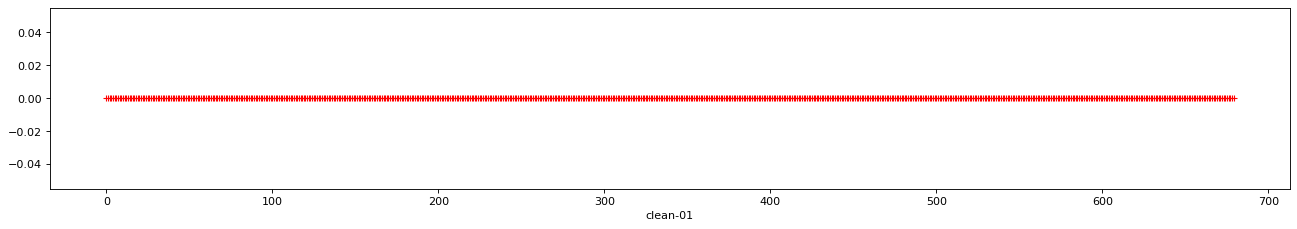

<Figure size 432x288 with 0 Axes>

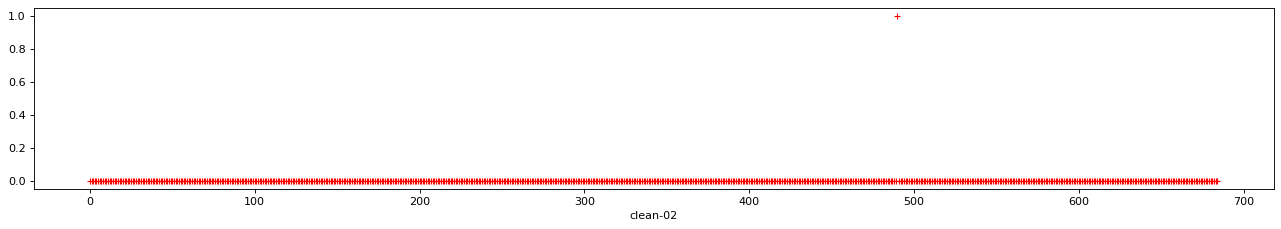

<Figure size 432x288 with 0 Axes>

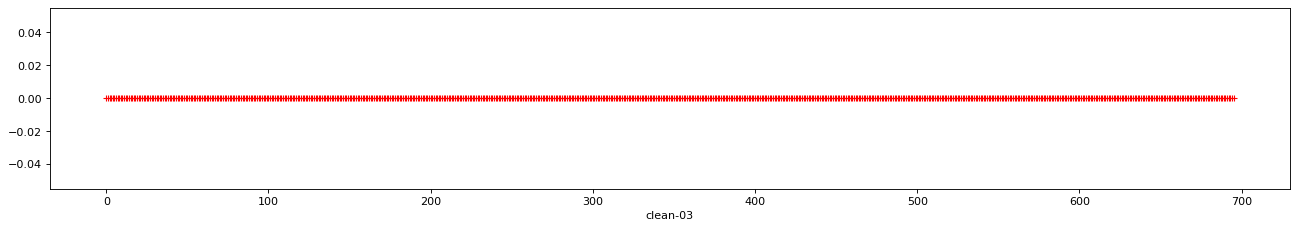

<Figure size 432x288 with 0 Axes>

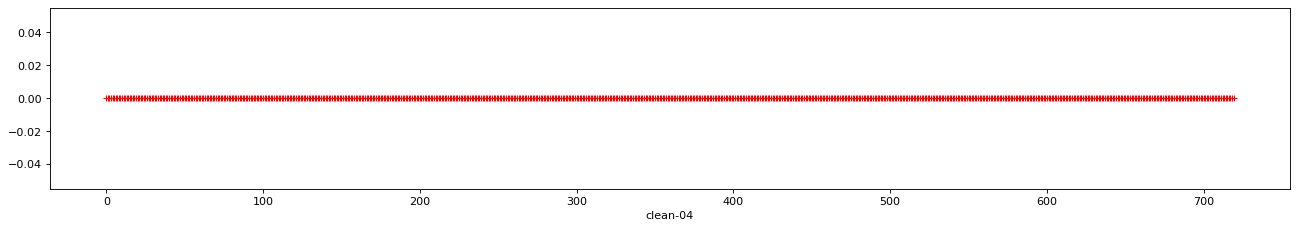

<Figure size 432x288 with 0 Axes>

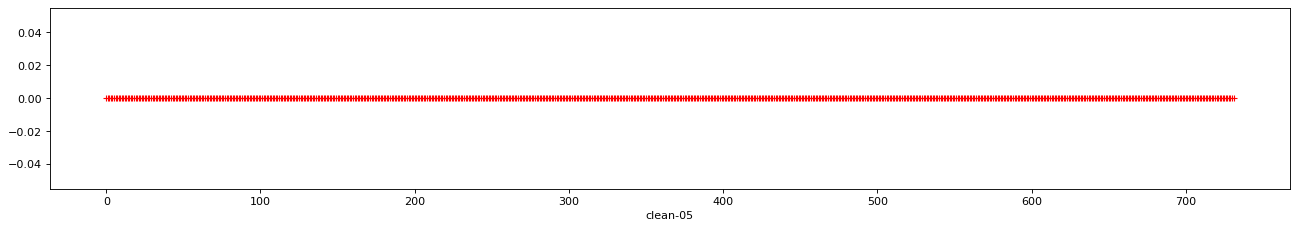

<Figure size 432x288 with 0 Axes>

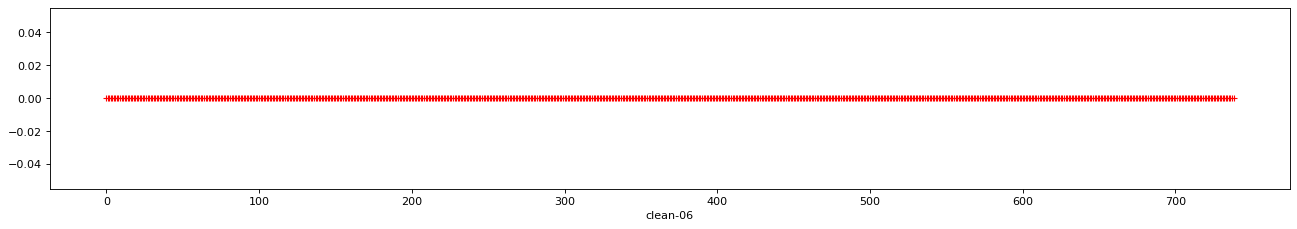

<Figure size 432x288 with 0 Axes>

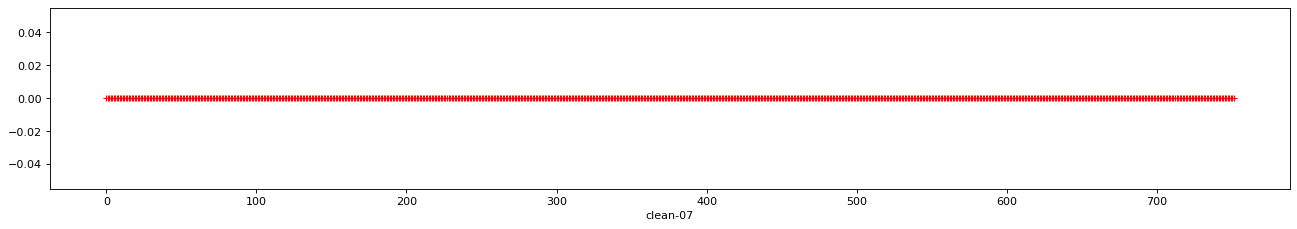

<Figure size 432x288 with 0 Axes>

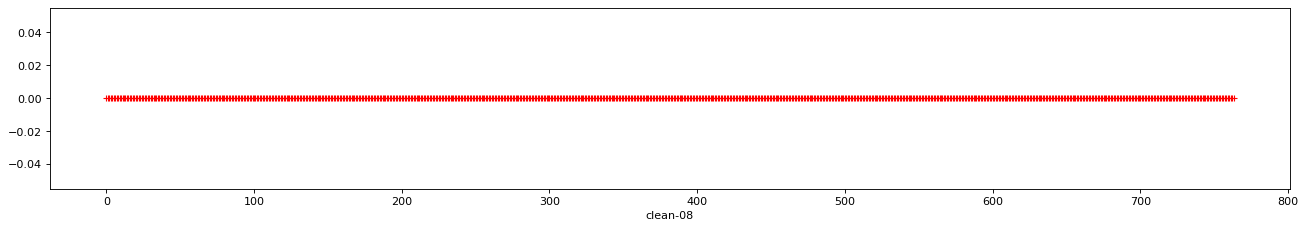

<Figure size 432x288 with 0 Axes>

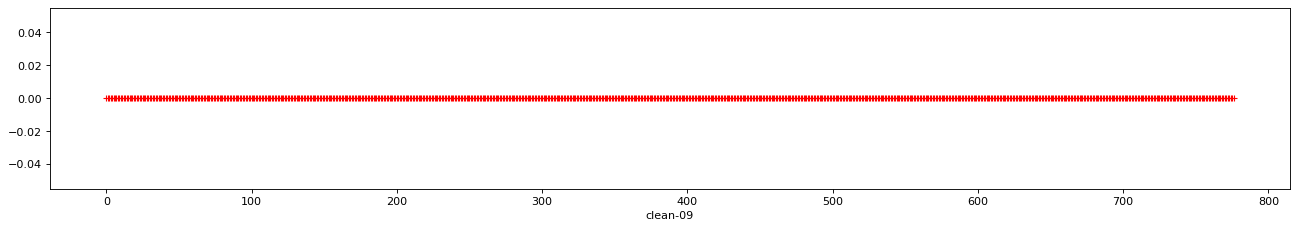

<Figure size 432x288 with 0 Axes>

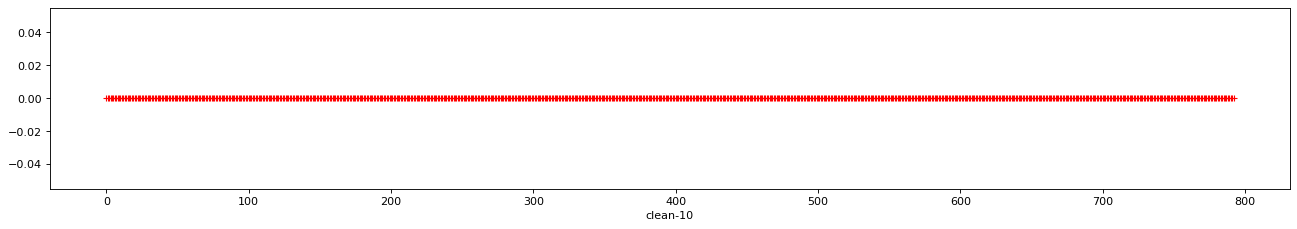

<Figure size 432x288 with 0 Axes>

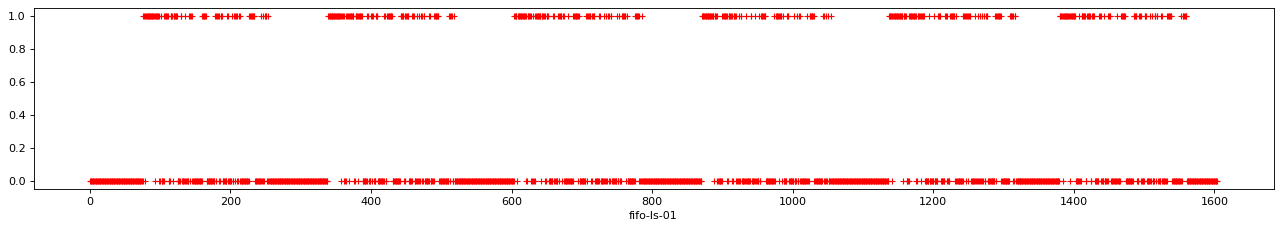

<Figure size 432x288 with 0 Axes>

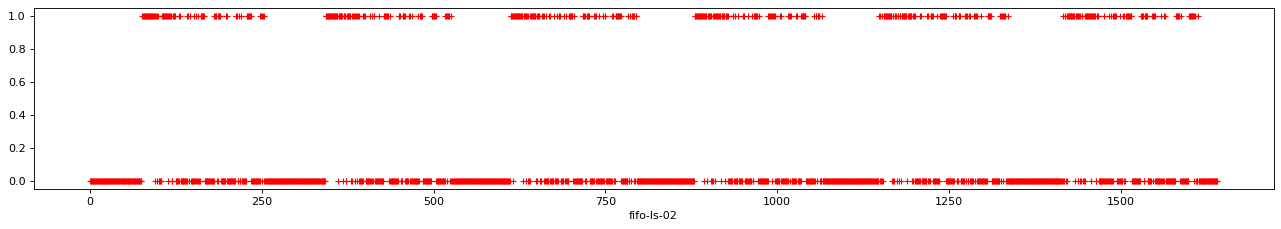

<Figure size 432x288 with 0 Axes>

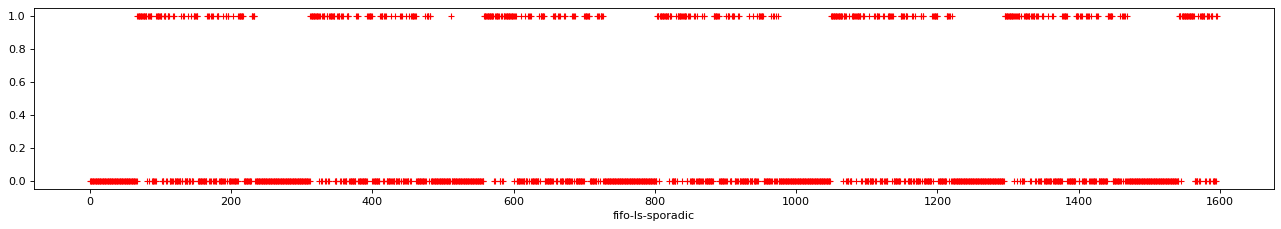

<Figure size 432x288 with 0 Axes>

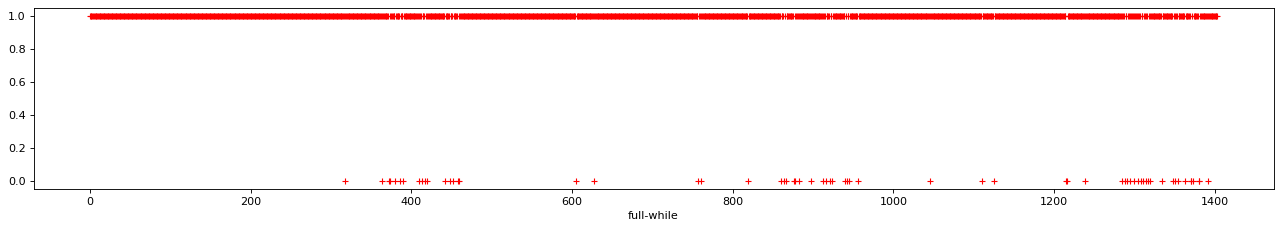

<Figure size 432x288 with 0 Axes>

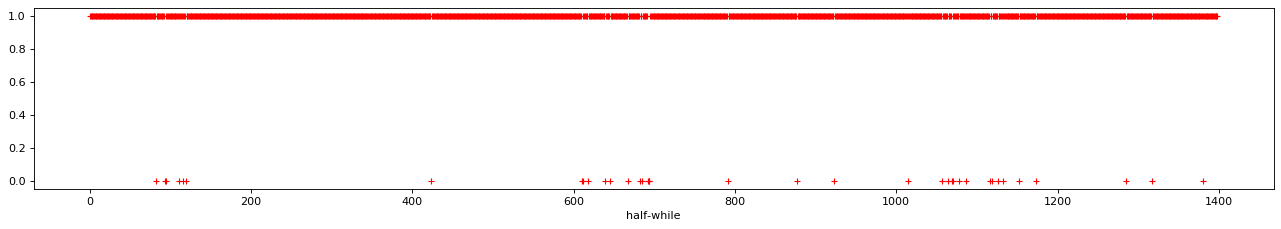

In [13]:
s=200
for j in range(len(sorted(name_list))):
  r=[]
  predicted=np.load('./gdrive/My Drive/Colab Notebooks/test_results/{}-predicted.npy'.format(sorted(name_list)[j]))
  target=np.load('./gdrive/My Drive/Colab Notebooks/test_results/{}-target.npy'.format(sorted(name_list)[j]))
  for i in range(0,target.shape[0]-s,s):
    predict=predicted.reshape((int(len(predicted)/5),5))
    pre=predict[i:i+s,:]
    tar=target[i:i+s,1:]

    count=np.sum(np.sum(np.not_equal(tar, pre)))/s/5

    anomaly=count>bar

    r.append(anomaly)
  plt.figure()
  fig=plt.figure(figsize=(20, 3), dpi= 80, facecolor='w', edgecolor='k')
  #plt.hlines(10,xmin=0,xmax=len(r),colors='r')
  plt.xlabel(sorted(name_list)[j])
  plt.plot(r,"r+")
  plt.show()

* visualize the anomalous events (continuous)

<Figure size 432x288 with 0 Axes>

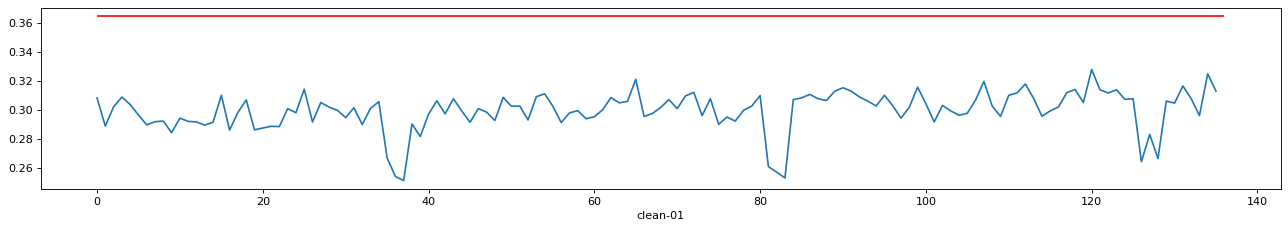

<Figure size 432x288 with 0 Axes>

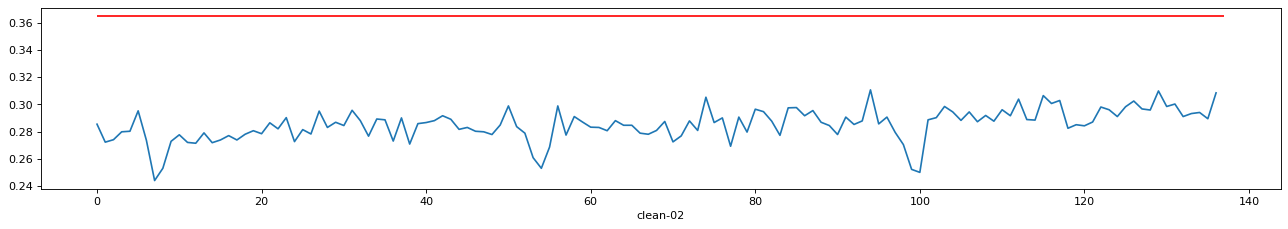

<Figure size 432x288 with 0 Axes>

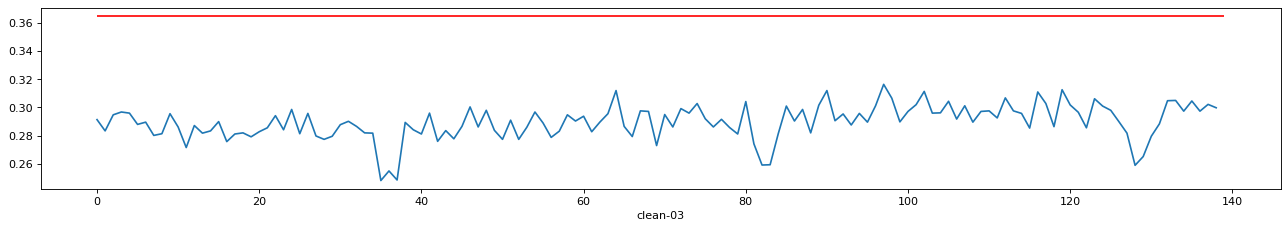

<Figure size 432x288 with 0 Axes>

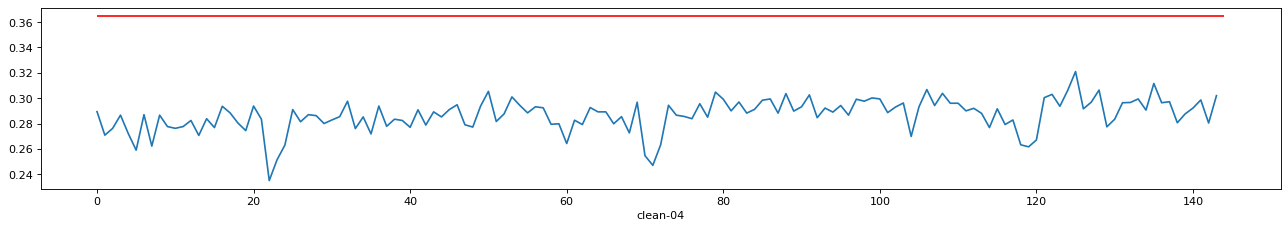

<Figure size 432x288 with 0 Axes>

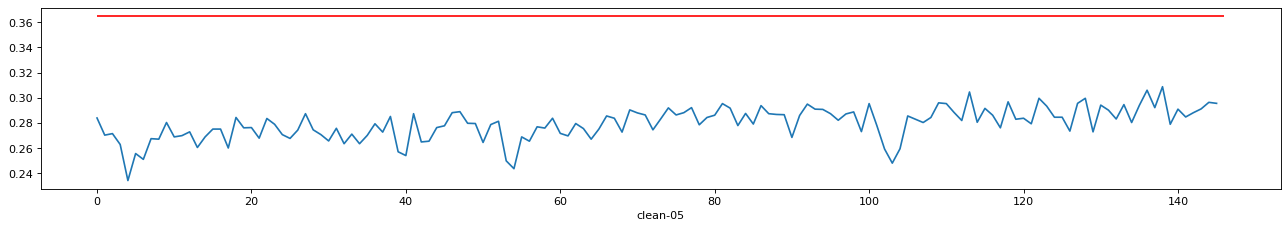

<Figure size 432x288 with 0 Axes>

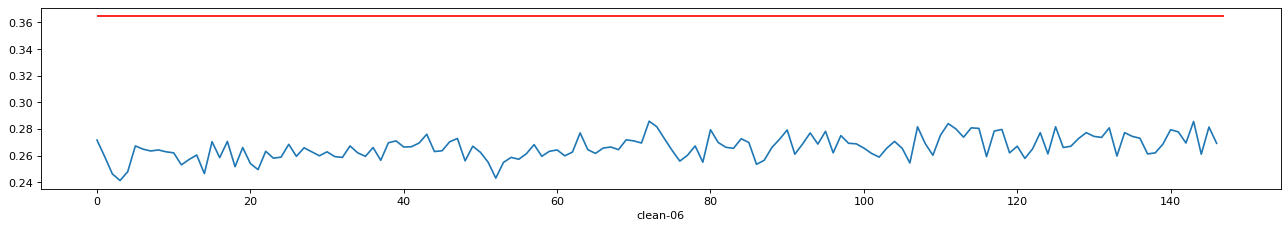

<Figure size 432x288 with 0 Axes>

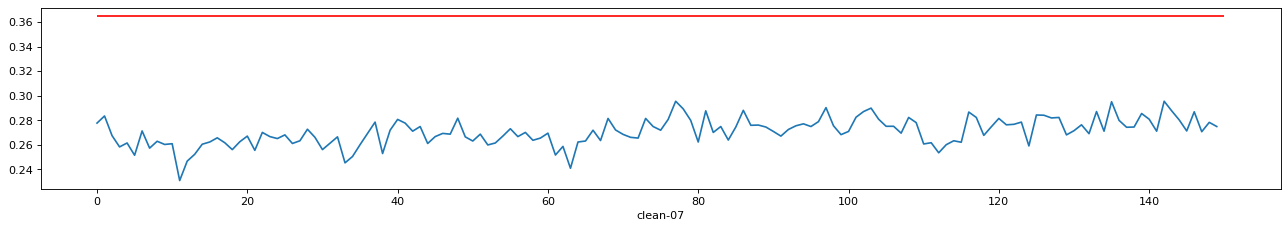

<Figure size 432x288 with 0 Axes>

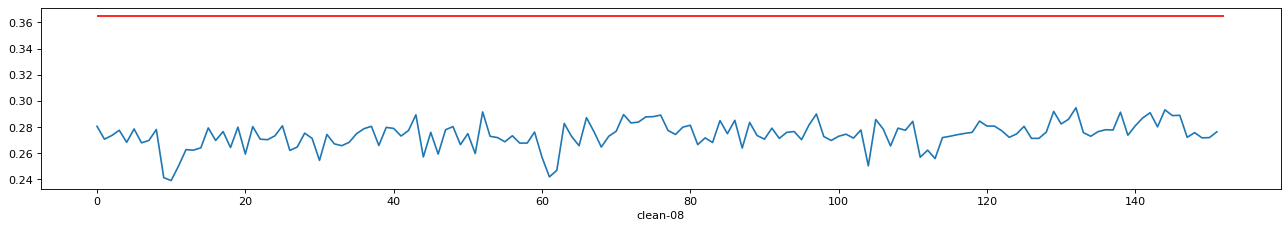

<Figure size 432x288 with 0 Axes>

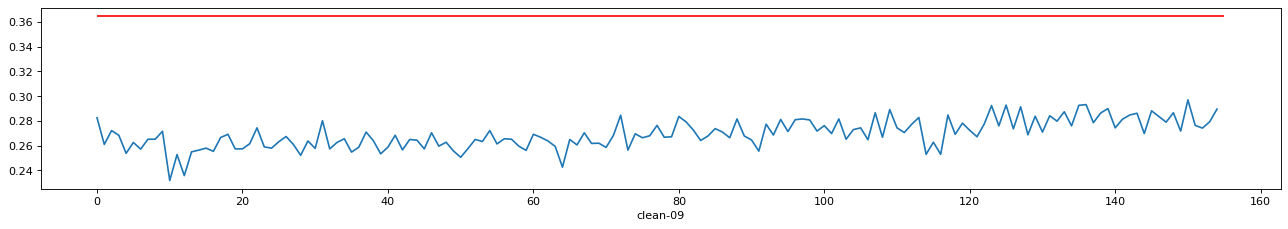

<Figure size 432x288 with 0 Axes>

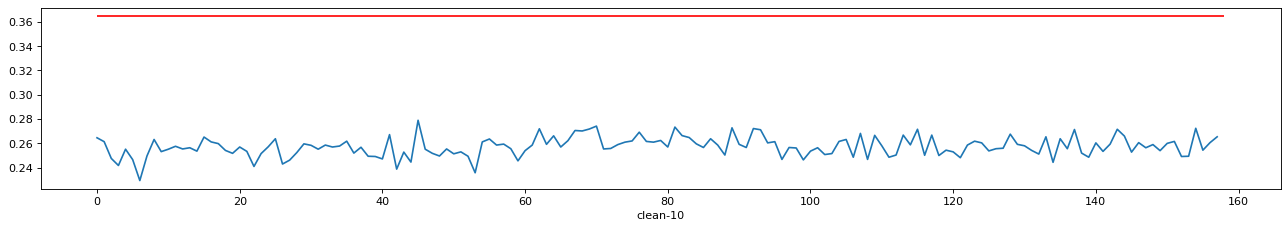

<Figure size 432x288 with 0 Axes>

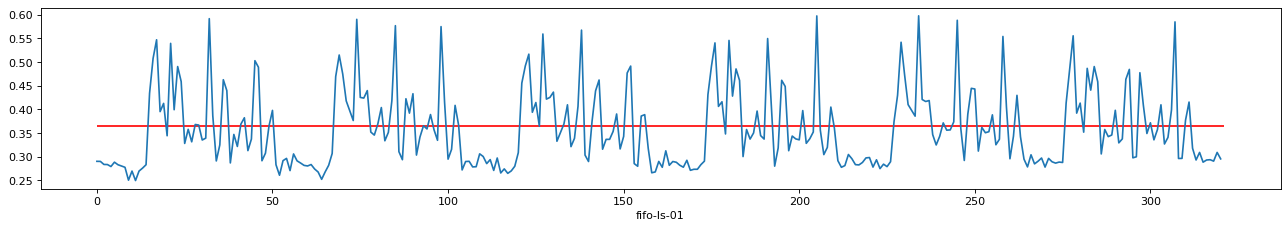

<Figure size 432x288 with 0 Axes>

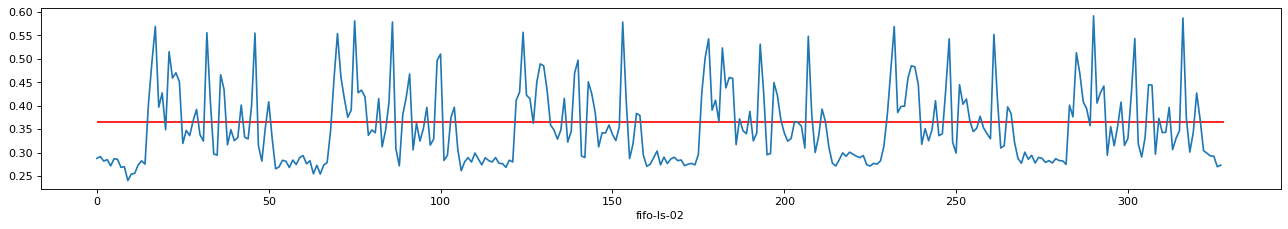

<Figure size 432x288 with 0 Axes>

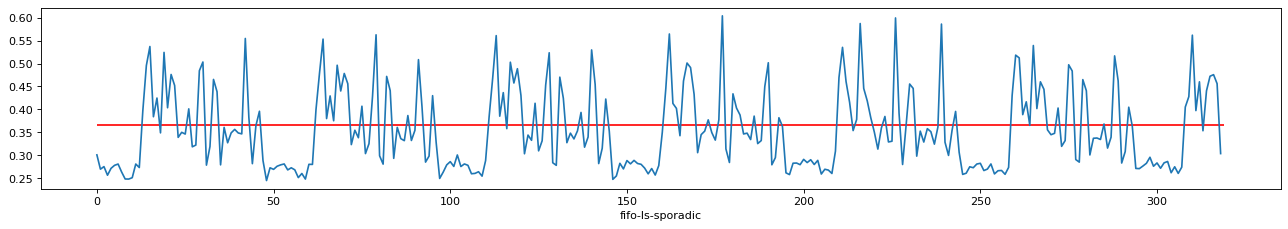

<Figure size 432x288 with 0 Axes>

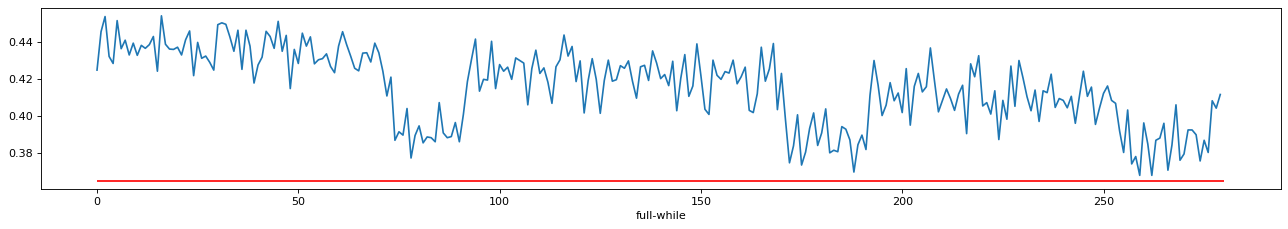

<Figure size 432x288 with 0 Axes>

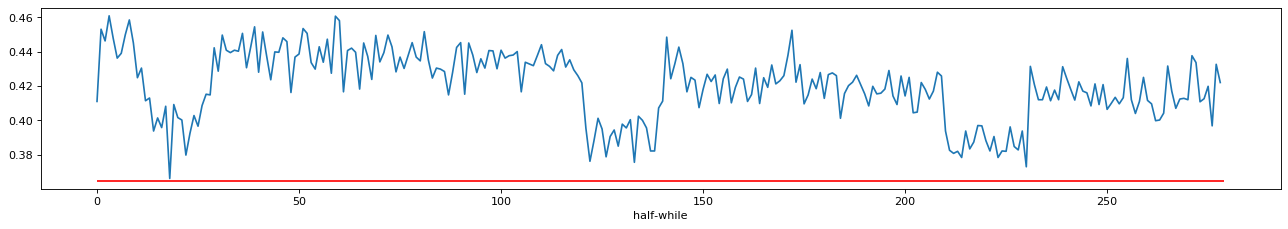

In [14]:
s=1000
for j in range(len(sorted(name_list))):
  r=[]
  predicted=np.load('./gdrive/My Drive/Colab Notebooks/test_results/{}-predicted.npy'.format(sorted(name_list)[j]))
  target=np.load('./gdrive/My Drive/Colab Notebooks/test_results/{}-target.npy'.format(sorted(name_list)[j]))
  for i in range(0,target.shape[0]-s,s):
    predict=predicted.reshape((int(len(predicted)/5),5))
    pre=predict[i:i+s,:]
    tar=target[i:i+s,1:]
    count=np.sum(np.sum(np.not_equal(tar, pre)))/s/5
    r.append(count)
  plt.figure()
  fig=plt.figure(figsize=(20, 3), dpi= 80, facecolor='w', edgecolor='k')
  plt.hlines(0.365,xmin=0,xmax=len(r),colors='r')
  plt.xlabel(sorted(name_list)[j])
  plt.plot(r)
  plt.show()

* track the anomaly sequences



In [0]:
predicted=np.load('./gdrive/My Drive/Colab Notebooks/test_results/{}-predicted.npy'.format(sorted(name_list)[10]))
target=np.load('./gdrive/My Drive/Colab Notebooks/test_results/{}-target.npy'.format(sorted(name_list)[10]))
inputs=np.load('./gdrive/My Drive/Colab Notebooks/test_results/{}-input.npy'.format(sorted(name_list)[10]))
index=[]
temp=[]
s=5
for i in range(0,target.shape[0]-s,s):
  predict=predicted.reshape((int(len(predicted)/5),5))
  pre=predict[i:i+s,:]
  tar=target[i:i+s,1:]
  if np.sum(np.not_equal(tar, pre))>19:
    index.append(list(range(i*5,(i+s)*5)))

In [17]:
# loading
with open('./gdrive/My Drive/Colab Notebooks/tokenizer.pickle', 'rb') as handle:
    seq_tokenizer = pickle.load(handle)

for i in range(len(index)):
  if i<10:
      print(seq_tokenizer.sequences_to_texts([inputs[:,1:].flatten()[index[i]]]))

['threadthsigwaitinfo processprocthread_name threadthcreate threadthreceive threadthcreate threadthreceive threadthcreate threadthreceive processprocthread_name threadthcreate threadthreceive processprocthread_name threadthcreate threadthready processprocthread_name threadthcreate threadthreceive processprocthread_name threadthcreate threadthreceive processprocthread_name processproccreate_name threadthcreate threadthsigwaitinfo processprocthread_name']
['threadthreceive threadthcreate threadthreceive threadthcreate threadthreceive processproccreate_name threadthcreate threadthreply processproccreate_name threadthcreate threadthsigwaitinfo processproccreate_name threadthcreate threadthjoin threadthcreate threadthreply threadthcreate threadthready threadthcreate threadthready processproccreate_name threadthcreate threadthsigwaitinfo processproccreate_name threadthcreate']
['ker_exitmsg_writev/17 ker_callmsg_replyv/15 commreply_message threadthready ker_exitmsg_replyv/15 int_entr0x000000

# Reference

* O. M. Ezeme, Q. H. Mahmoud and A. Azim, "DReAM: Deep Recursive Attentive Model for Anomaly Detection in Kernel Events," in IEEE Access, vol. 7, pp. 18860-18870, 2019.

* https://www.tensorflow.org/tutorials/text/nmt_with_attention